In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             f1_score, roc_auc_score, roc_curve, auc)
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/kaggle/input/nypd-cleaned/nypd_cleaned.csv')
print(f"Dataset shape: {data.shape}")

Dataset shape: (9490262, 23)


In [3]:
data['is_weekend'] = data['weekday'].isin(['Saturday', 'Sunday']).astype(int)
data['is_night'] = ((data['hour'] >= 20) | (data['hour'] <= 6)).astype(int)
data['is_rush_hour'] = data['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)

# Season feature
data['season'] = pd.cut(data['month'], bins=[0, 3, 6, 9, 12], 
                        labels=['Winter', 'Spring', 'Summer', 'Fall'])

# Crime density by location (simplified grouping)
data['location_key'] = data['Latitude'].round(2).astype(str) + '_' + data['Longitude'].round(2).astype(str)
location_crime_count = data['location_key'].value_counts()
data['location_crime_density'] = data['location_key'].map(location_crime_count)

print("Feature engineering completed!")

Feature engineering completed!


In [4]:
label_encoders = {}
categorical_cols = ['weekday', 'COMPLETED', 'CRIME_CATEGORY', 'CRIME_CLASS', 
                    'BORO_NM', 'PREM_TYP_DESC', 'OCCURENCE', 'JURIS_DESC',
                    'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX',
                    'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'season']

for col in categorical_cols:
    le = LabelEncoder()
    data[col + '_encoded'] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

In [5]:
feature_cols = ['year', 'month', 'day', 'hour', 'Latitude', 'Longitude',
                'ADDR_PCT_CD', 'JURISDICTION_CODE',
                'weekday_encoded', 'COMPLETED_encoded', 'CRIME_CLASS_encoded',
                'BORO_NM_encoded', 'PREM_TYP_DESC_encoded', 'OCCURENCE_encoded',
                'SUSP_AGE_GROUP_encoded', 'SUSP_RACE_encoded', 'SUSP_SEX_encoded',
                'VIC_AGE_GROUP_encoded', 'VIC_RACE_encoded', 'VIC_SEX_encoded',
                'season_encoded', 'is_weekend', 'is_night', 'is_rush_hour',
                'location_crime_density']

X = data[feature_cols]
y = data['CRIME_CATEGORY_encoded']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of classes: {y.nunique()}")

Features shape: (9490262, 25)
Target shape: (9490262,)
Number of classes: 6


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Training set: (7592209, 25)
Test set: (1898053, 25)


In [7]:
def evaluate_model(model, X_test, y_test, y_pred, model_name, y_train=None):
    """Comprehensive model evaluation with visualizations"""
    
    print(f"\n{'='*60}")
    print(f"{model_name} EVALUATION")
    print(f"{'='*60}")
    
    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, 
                                target_names=label_encoders['CRIME_CATEGORY'].classes_))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoders['CRIME_CATEGORY'].classes_,
                yticklabels=label_encoders['CRIME_CATEGORY'].classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # ROC Curve (One-vs-Rest for multiclass)
    n_classes = len(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    
    # Get probability predictions
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test)
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot ROC curves
        plt.figure(figsize=(12, 8))
        colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
        
        for i, color, class_name in zip(range(n_classes), colors, 
                                         label_encoders['CRIME_CATEGORY'].classes_):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve (One-vs-Rest) - {model_name}')
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Calculate macro-average ROC AUC
        macro_roc_auc = roc_auc_score(y_test_bin, y_score, average='macro')
        print(f"\nMacro-average ROC AUC: {macro_roc_auc:.4f}")
    
    # Feature importance (if available)
    if hasattr(model, 'feature_importances_'):
        feature_imp = pd.DataFrame({
            'feature': feature_cols,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False).head(15)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_imp, x='importance', y='feature', palette='viridis')
        plt.title(f'Top 15 Feature Importances - {model_name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    
    return accuracy, f1


TRAINING DECISION TREE

Decision Tree EVALUATION
Accuracy: 0.6824
F1-Score (weighted): 0.7044

Classification Report:
                precision    recall  f1-score   support

ADMINISTRATIVE       0.40      0.62      0.49    179946
 DRUGS/ALCOHOL       0.54      0.87      0.67    116390
         OTHER       0.22      0.65      0.33     68122
      PERSONAL       0.53      0.46      0.49    324124
      PROPERTY       0.92      0.67      0.78    924509
        SEXUAL       0.97      0.93      0.95    284962

      accuracy                           0.68   1898053
     macro avg       0.60      0.70      0.62   1898053
  weighted avg       0.76      0.68      0.70   1898053



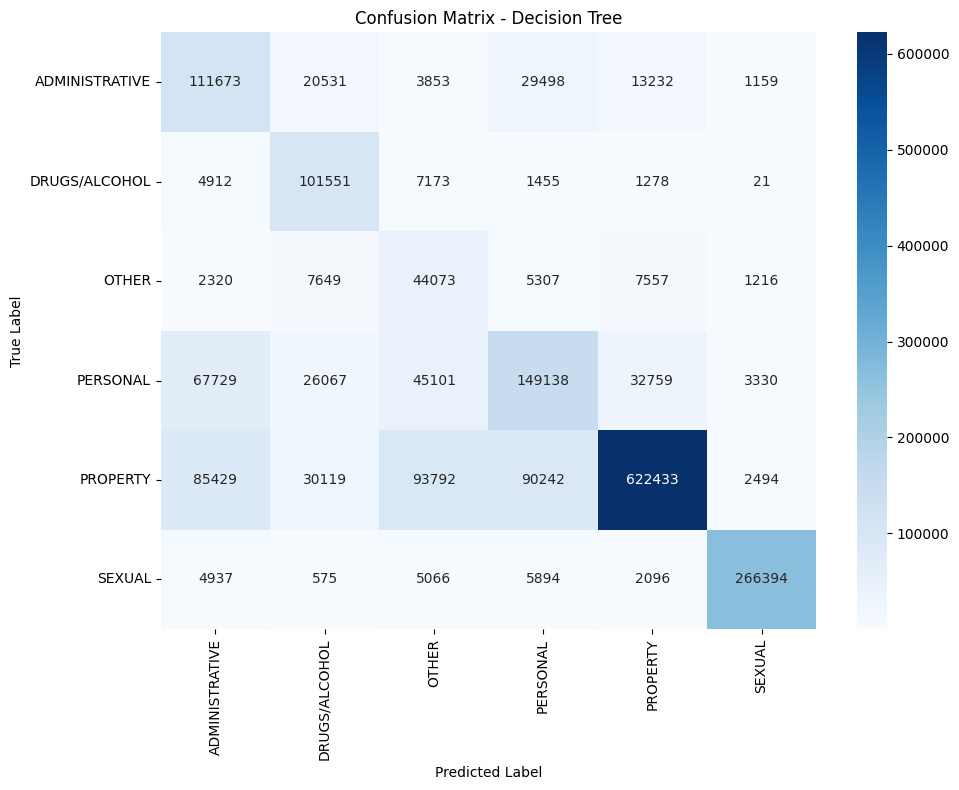

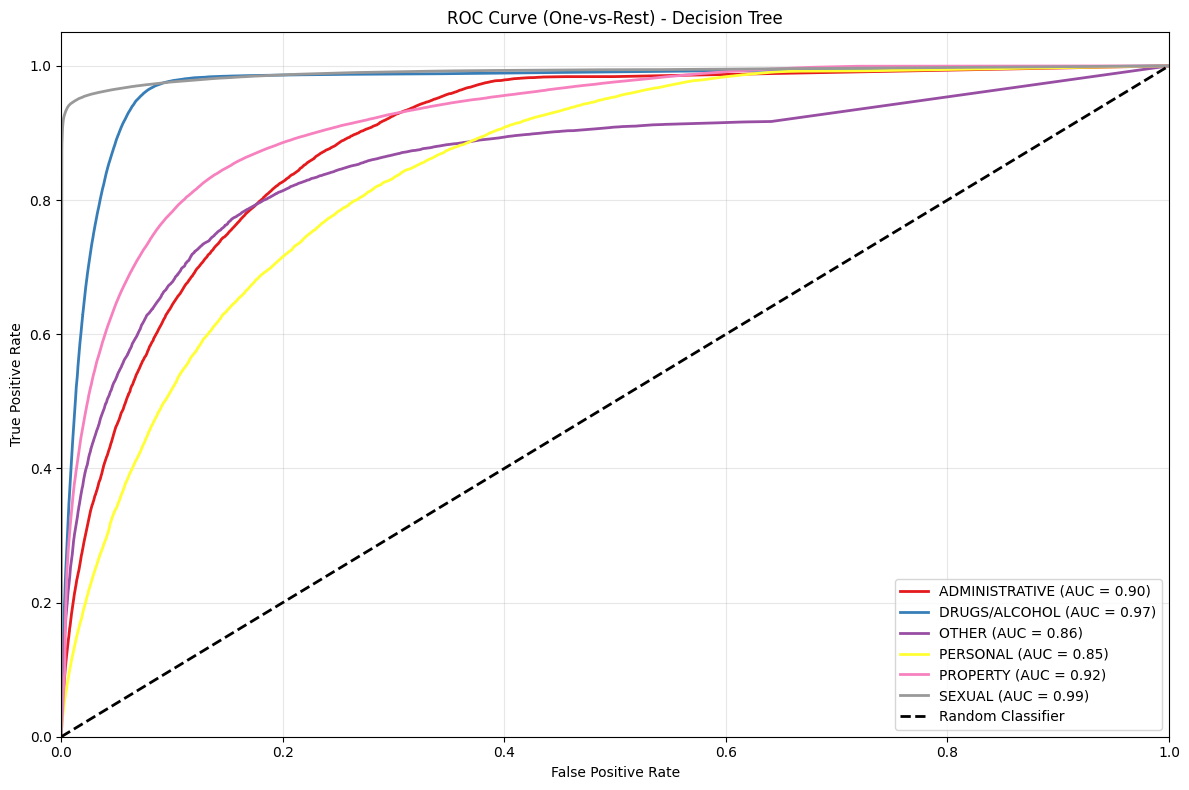


Macro-average ROC AUC: 0.9153


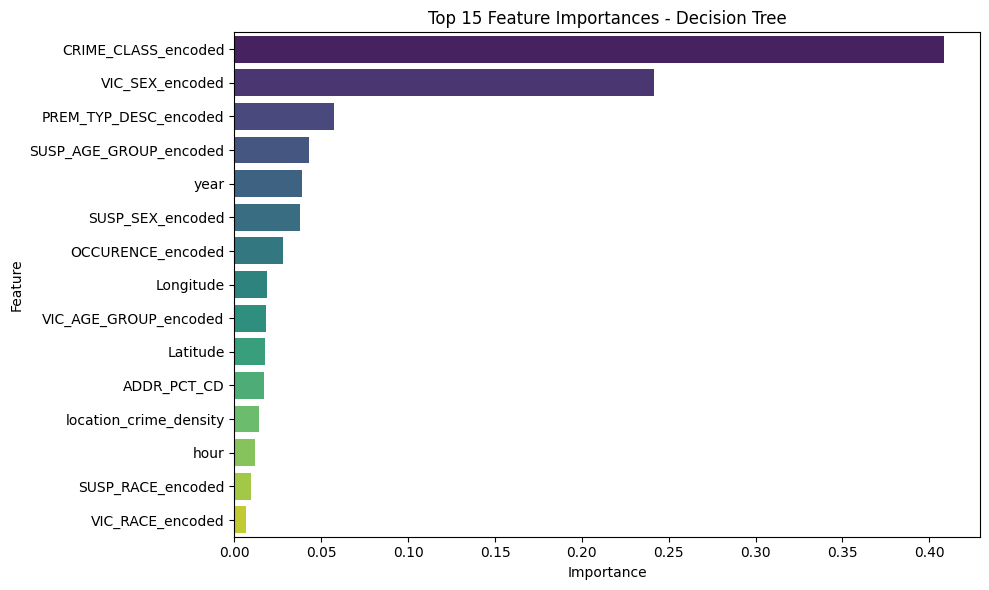

['random_forest_model.pkl']

In [8]:
from sklearn.tree import DecisionTreeClassifier

print("\n" + "="*60)
print("TRAINING DECISION TREE")
print("="*60)

dt_model = DecisionTreeClassifier(
    max_depth=20,  # Increased depth
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

dt_acc, dt_f1 = evaluate_model(dt_model, X_test, y_test, dt_pred, "Decision Tree")
joblib.dump(dt_model, 'random_forest_model.pkl')



TRAINING LIGHTGBM

LightGBM EVALUATION
Accuracy: 0.7058
F1-Score (weighted): 0.7236

Classification Report:
                precision    recall  f1-score   support

ADMINISTRATIVE       0.42      0.62      0.50    179946
 DRUGS/ALCOHOL       0.53      0.90      0.67    116390
         OTHER       0.25      0.65      0.37     68122
      PERSONAL       0.56      0.47      0.51    324124
      PROPERTY       0.92      0.70      0.80    924509
        SEXUAL       0.99      0.97      0.98    284962

      accuracy                           0.71   1898053
     macro avg       0.61      0.72      0.64   1898053
  weighted avg       0.77      0.71      0.72   1898053



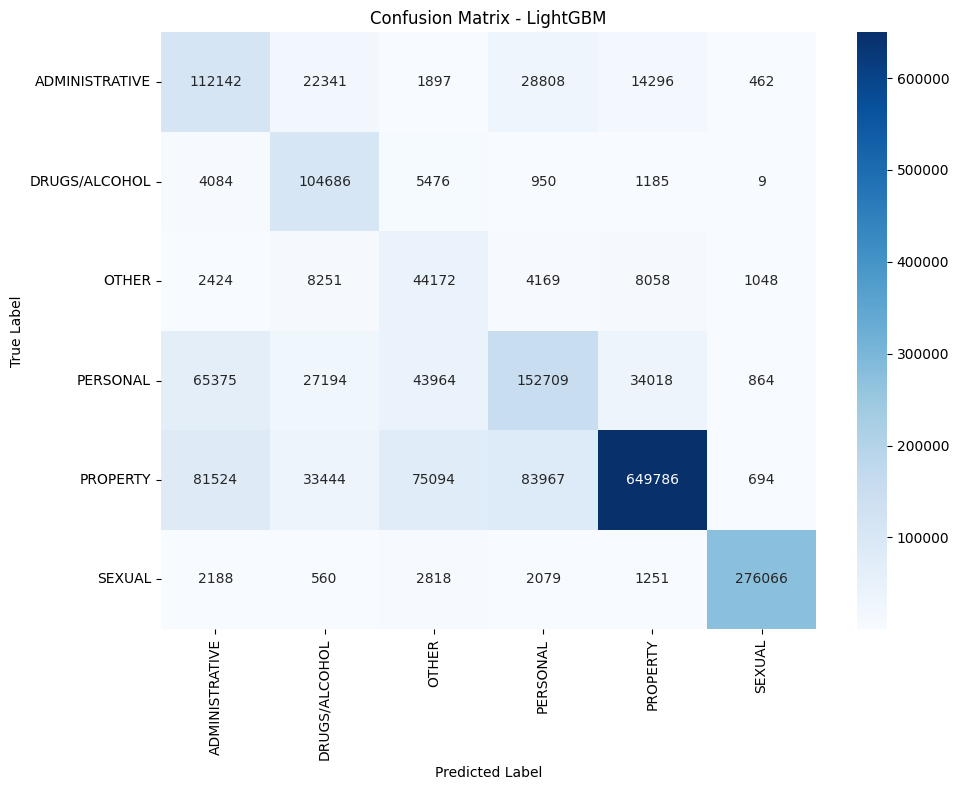

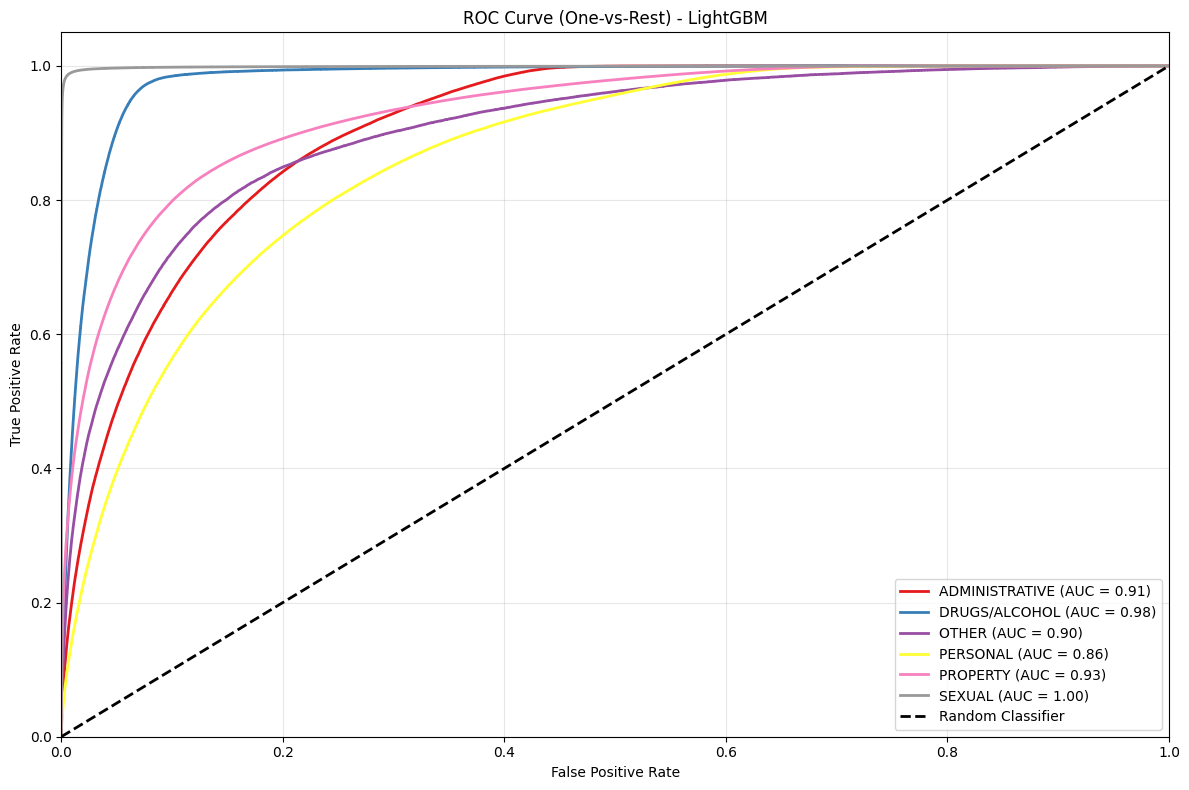


Macro-average ROC AUC: 0.9297


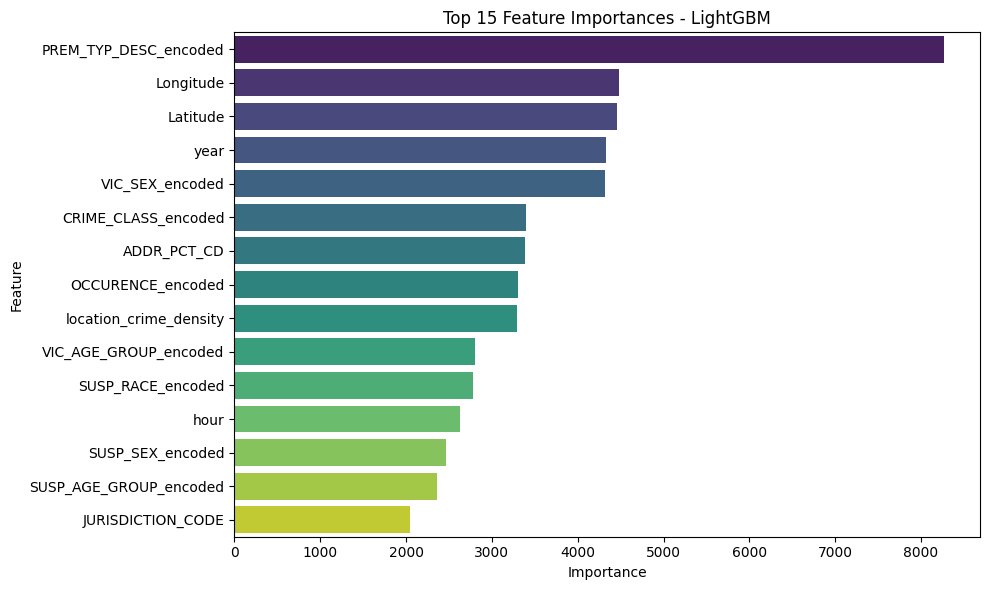

['lightgbm_model.pkl']

In [9]:
from lightgbm import LGBMClassifier

print("\n" + "="*60)
print("TRAINING LIGHTGBM")
print("="*60)

lgbm_model = LGBMClassifier(
    n_estimators=200,  # Increased
    max_depth=10,  # Increased
    learning_rate=0.05,  # Decreased for better convergence
    num_leaves=50,
    min_child_samples=30,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    class_weight='balanced'
)
lgbm_model.fit(X_train, y_train)
lgbm_pred = lgbm_model.predict(X_test)

lgbm_acc, lgbm_f1 = evaluate_model(lgbm_model, X_test, y_test, lgbm_pred, "LightGBM")
joblib.dump(lgbm_model, 'lightgbm_model.pkl')


TRAINING XGBOOST

XGBoost EVALUATION
Accuracy: 0.7721
F1-Score (weighted): 0.7628

Classification Report:
                precision    recall  f1-score   support

ADMINISTRATIVE       0.59      0.40      0.48    179946
 DRUGS/ALCOHOL       0.60      0.83      0.70    116390
         OTHER       0.58      0.29      0.39     68122
      PERSONAL       0.58      0.55      0.57    324124
      PROPERTY       0.83      0.89      0.86    924509
        SEXUAL       0.99      0.96      0.98    284962

      accuracy                           0.77   1898053
     macro avg       0.69      0.65      0.66   1898053
  weighted avg       0.76      0.77      0.76   1898053



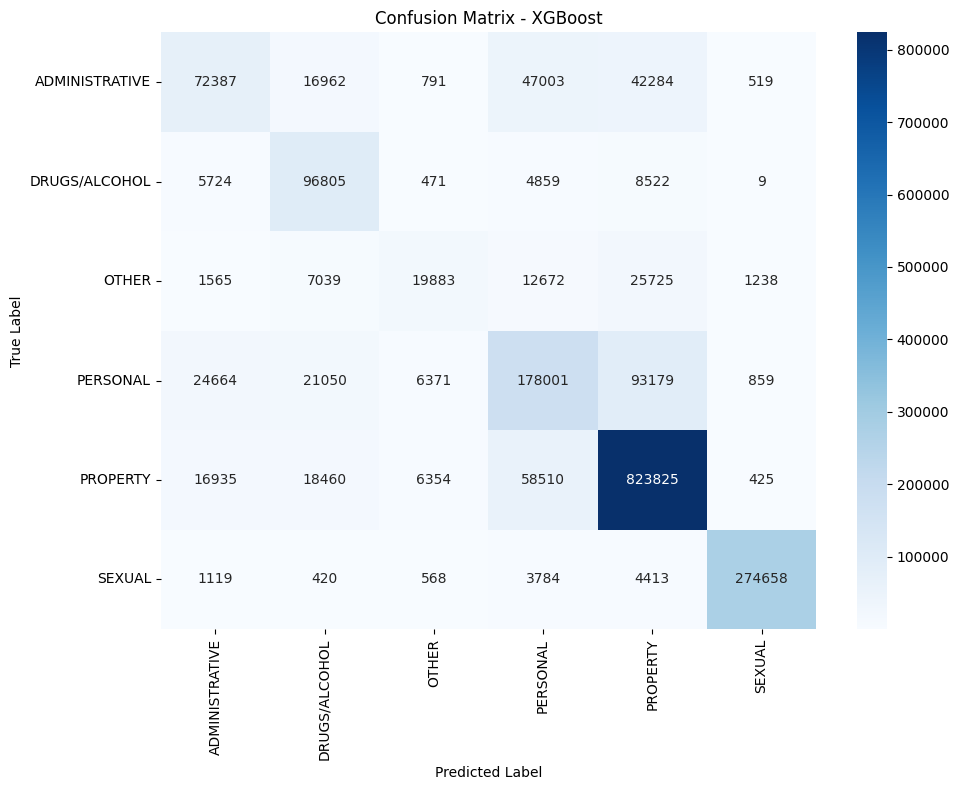

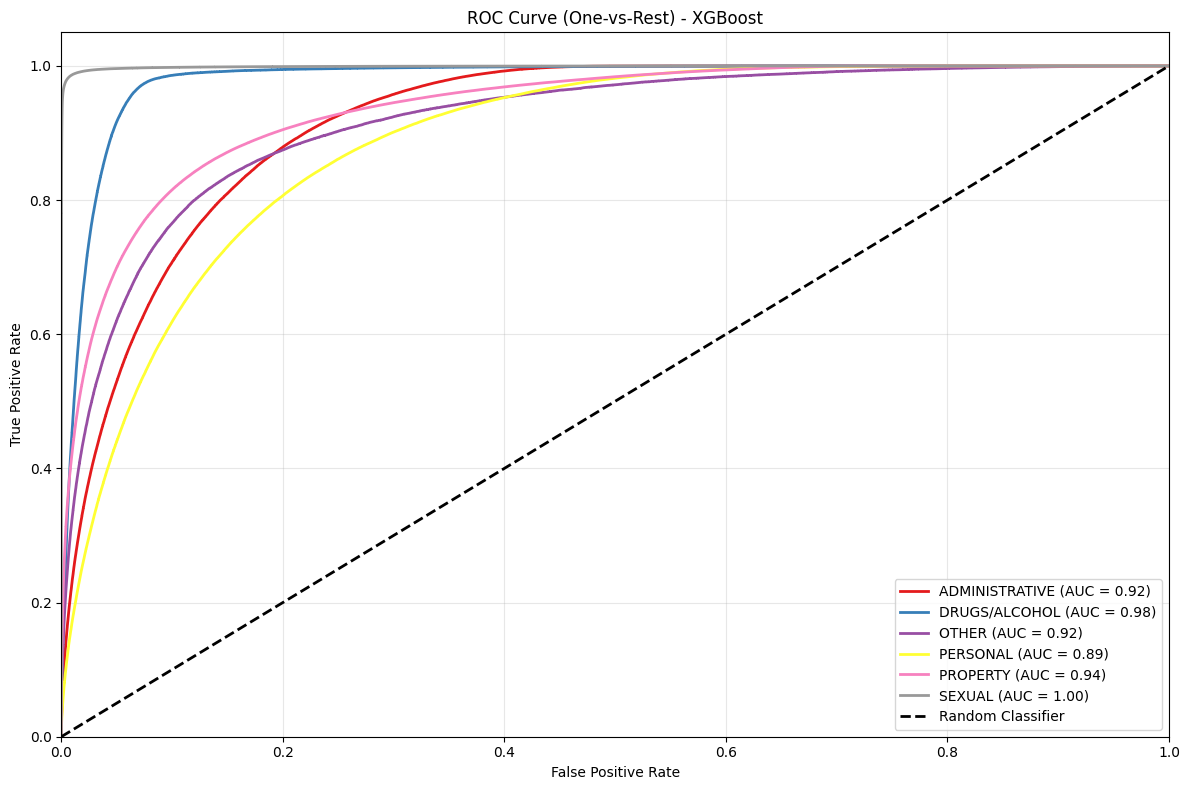


Macro-average ROC AUC: 0.9399


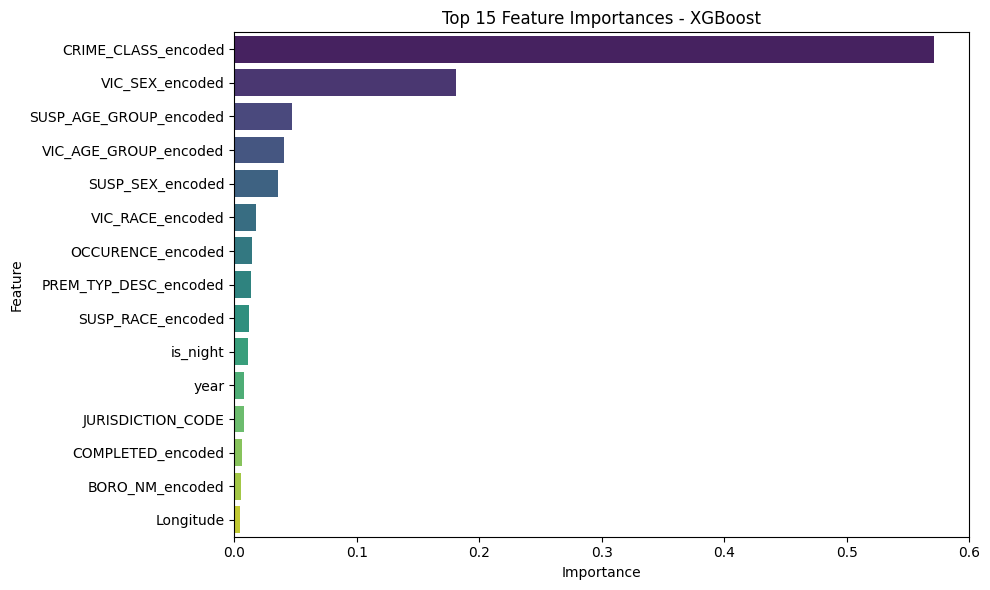

['xgboost_model.pkl']

In [10]:
from xgboost import XGBClassifier

print("\n" + "="*60)
print("TRAINING XGBOOST")
print("="*60)

xgb_model = XGBClassifier(
    n_estimators=200,  # Increased
    max_depth=10,  # Increased
    learning_rate=0.05,  # Decreased
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

xgb_acc, xgb_f1 = evaluate_model(xgb_model, X_test, y_test, xgb_pred, "XGBoost")
joblib.dump(xgb_model, 'xgboost_model.pkl')


TRAINING RANDOM FOREST

Random Forest EVALUATION
Accuracy: 0.7177
F1-Score (weighted): 0.7326

Classification Report:
                precision    recall  f1-score   support

ADMINISTRATIVE       0.44      0.61      0.51    179946
 DRUGS/ALCOHOL       0.53      0.91      0.67    116390
         OTHER       0.29      0.62      0.39     68122
      PERSONAL       0.56      0.49      0.52    324124
      PROPERTY       0.91      0.74      0.81    924509
        SEXUAL       0.99      0.93      0.96    284962

      accuracy                           0.72   1898053
     macro avg       0.62      0.72      0.64   1898053
  weighted avg       0.77      0.72      0.73   1898053



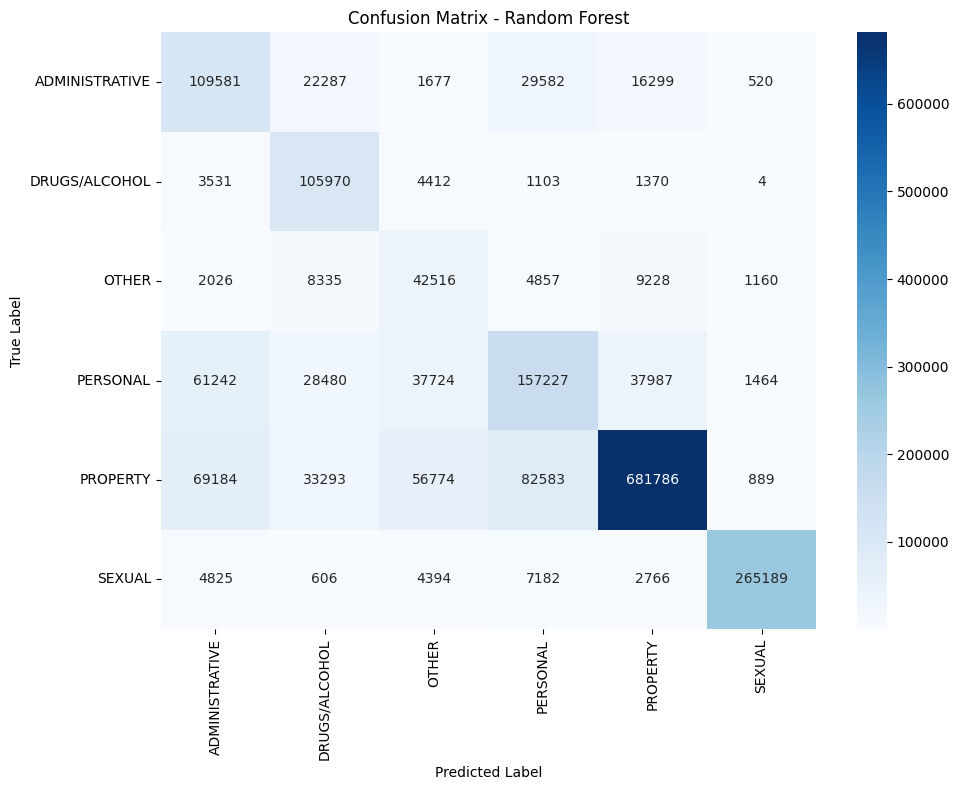

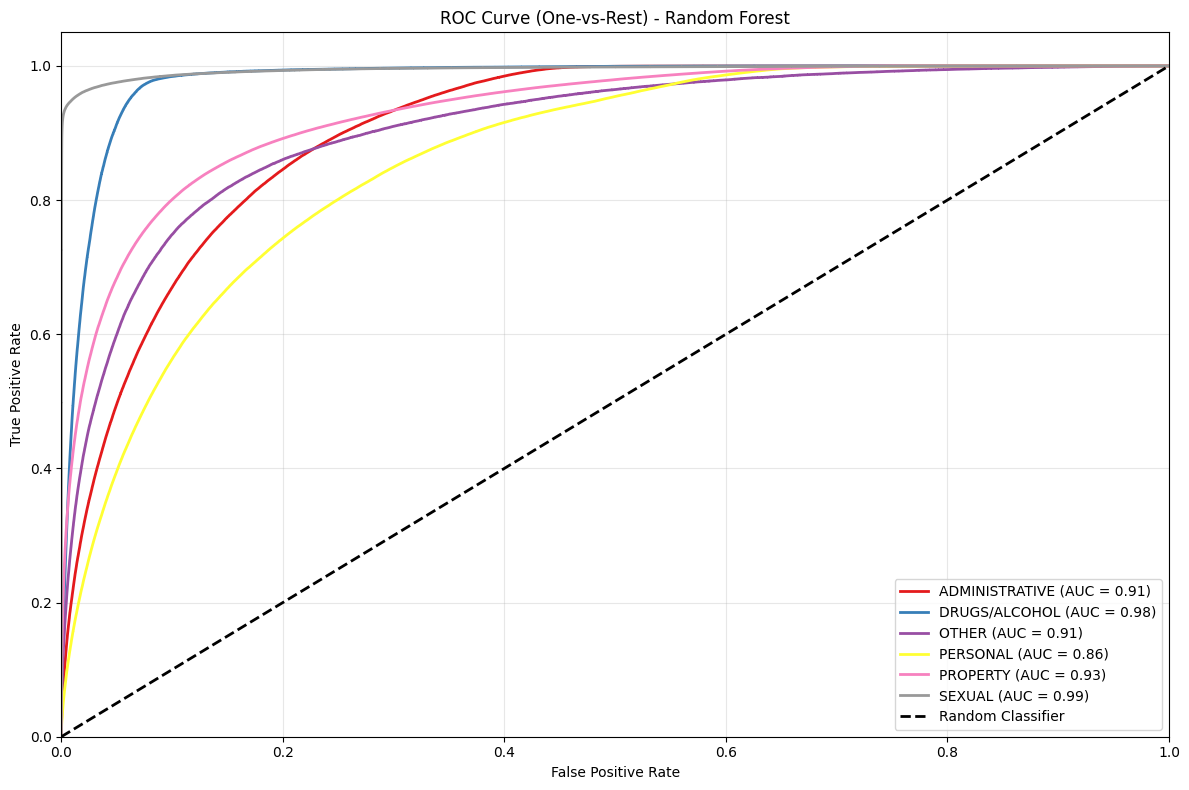


Macro-average ROC AUC: 0.9304


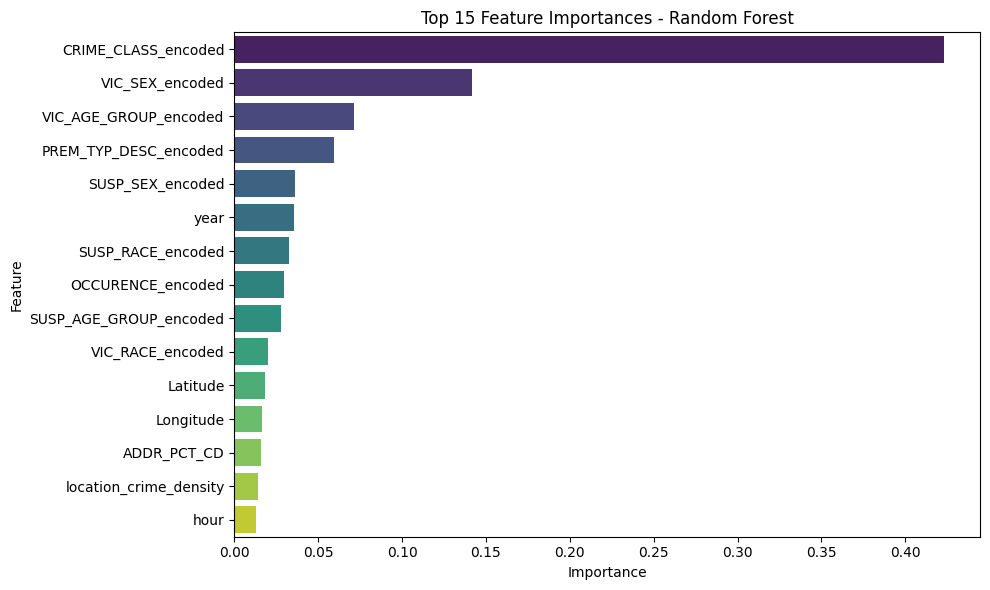

['random_forest_model.pkl']

In [11]:
from sklearn.ensemble import RandomForestClassifier

print("\n" + "="*60)
print("TRAINING RANDOM FOREST")
print("="*60)

rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=20,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_acc, rf_f1 = evaluate_model(rf_model, X_test, y_test, rf_pred, "Random Forest")
joblib.dump(rf_model, 'random_forest_model.pkl')

In [12]:
joblib.dump(scaler, '/kaggle/working/scaler.pkl')
joblib.dump(label_encoders, '/kaggle/working/label_encoders.pkl')
print("\n✓ Scaler saved as 'scaler.pkl'")
print("✓ Label encoders saved as 'label_encoders.pkl'")
print("\n📁 All models saved to /kaggle/working/ directory")
print("You can download them from the Output section on the right →")


✓ Scaler saved as 'scaler.pkl'
✓ Label encoders saved as 'label_encoders.pkl'

📁 All models saved to /kaggle/working/ directory
You can download them from the Output section on the right →



MODEL COMPARISON SUMMARY
        Model  Accuracy  F1-Score
Decision Tree  0.682416  0.704403
     LightGBM  0.705755  0.723603
      XGBoost  0.772138  0.762839
Random Forest  0.717719  0.732617


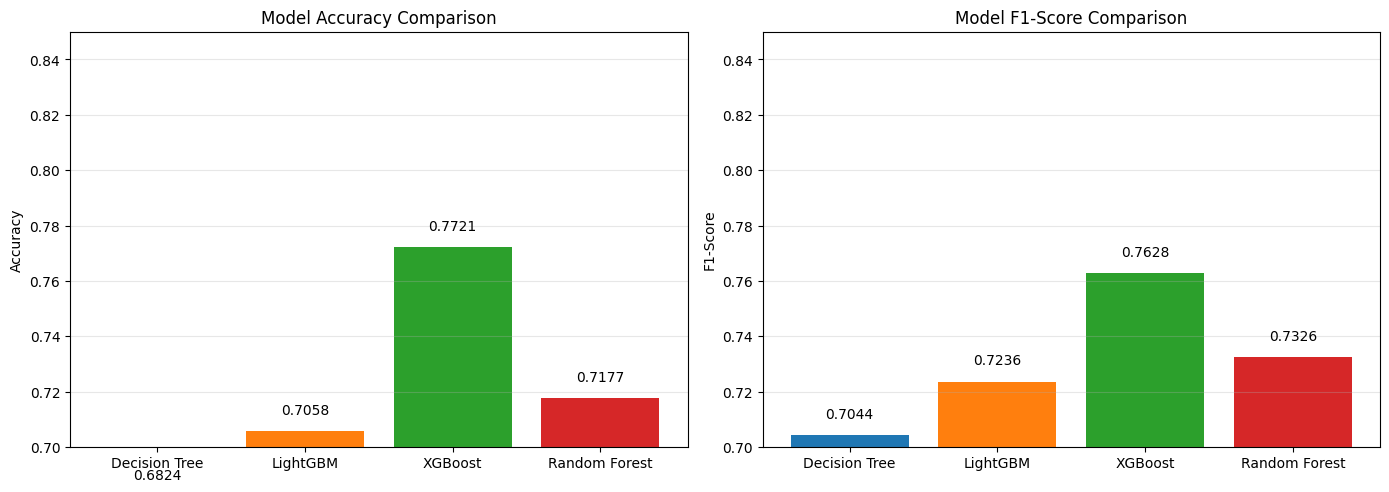


BEST MODEL: XGBoost


In [13]:
results = pd.DataFrame({
    'Model': ['Decision Tree', 'LightGBM', 'XGBoost', 'Random Forest'],
    'Accuracy': [dt_acc, lgbm_acc, xgb_acc, rf_acc],
    'F1-Score': [dt_f1, lgbm_f1, xgb_f1, rf_f1]
})

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(results.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].bar(results['Model'], results['Accuracy'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylim([0.7, 0.85])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(results['Accuracy']):
    axes[0].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom')

# F1-Score comparison
axes[1].bar(results['Model'], results['F1-Score'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1].set_ylabel('F1-Score')
axes[1].set_title('Model F1-Score Comparison')
axes[1].set_ylim([0.7, 0.85])
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(results['F1-Score']):
    axes[1].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("BEST MODEL:", results.loc[results['Accuracy'].idxmax(), 'Model'])
print("="*60)